In [1]:
import numpy as np
import pandas as pd

# year = 252 days
# quarter = 63 days
# month = 21 days

# GET PRICE HISTORY

In [2]:
def get_price_history(file):
    df = pd.read_csv(file, parse_dates=['Date'])
    df = df.pivot(index='Date', columns='Symbol', values='Adj Close')
    return df


idx_price_history = get_price_history('idx_values.csv')
dow_price_history = get_price_history('dow_values.csv')
sp5_price_history = get_price_history('sp5_values.csv')

# display(idx_price_history.info())
# display(dow_price_history.info())
# display(sp5_price_history.info())

# display(idx_price_history)
# display(dow_price_history)
# display(sp5_price_history)

# GET RETURN HISTORY

In [3]:
def get_return_history(df, days):
    df = (df/df.shift(days) - 1).dropna(axis=0, how='all')*100
    return df


# idx_return_history = get_return_history(idx_price_history, 252)
# dow_return_history = get_return_history(dow_price_history, 252)
# sp5_return_history = get_return_history(sp5_price_history, 252)

# display(idx_return_history)
# display(dow_return_history)
# display(sp5_return_history)

# GET QUANTILE HISTORY

In [4]:
def get_quantile_history(df, window, quantile):
    df = df.rolling(window).quantile(quantile).dropna(axis=0, how='all')
    return df


# idx_quantile_history = get_quantile_history(idx_return_history, 252*2, 0.95)
# dow_quantile_history = get_quantile_history(dow_return_history, 252*2, 0.95)
# sp5_quantile_history = get_quantile_history(sp5_return_history, 252*2, 0.95)

# display(idx_quantile_history)
# display(dow_quantile_history)
# display(sp5_quantile_history)

# GET RANK HISTORY

In [5]:
# def get_rank_history(df, days):
#     df = df.tail(days).dropna(axis=1, how='any')
#     df = df.rank(axis=1, method='first', ascending=False)
#     df = df.astype('int64')
#     return df


def get_rank_history(df, start_date):
    logic = df.index >= start_date
    df = df[logic].dropna(axis=1, how='any')
    df = df.rank(axis=1, method='first', ascending=False)
    df = df.astype('int64')
    return df


# start_date = pd.Timestamp('3-30-2022')
# dow_rank_history = get_rank_history(dow_quantile_history, start_date)
# sp5_rank_history = get_rank_history(sp5_quantile_history, start_date)

# display(dow_rank_history)
# display(sp5_rank_history)

# TRADE

In [6]:
def get_sell_symbols(positions, ranks, bad_rank):
    logic = ranks > bad_rank
    bad_symbols = ranks[logic].index
    logic = positions.index.isin(bad_symbols)
    sell_symbols = positions[logic].index
    return sell_symbols


def get_buy_symbols(positions, ranks, num_buy):
    logic = ~ranks.index.isin(positions.index)
    buy_symbols = ranks[logic].nsmallest(num_buy).index
    return buy_symbols


def trade(price_history, rank_history, start_cash, start_hold, bad_factor):
    
    cash = start_cash
    symbol_cash = start_cash/start_hold
    
    positions = pd.Series(dtype='float64')
    values = pd.Series(dtype='float64')
    transactions = []

    for date, ranks in rank_history.iterrows():
        prices = price_history.loc[date]  
        ranks = rank_history.loc[date]  

        bad_rank = len(positions)*bad_factor
        sell_symbols = get_sell_symbols(positions, ranks, bad_rank)
        for symbol in sell_symbols:
            price = prices[symbol]
            shares = positions[symbol]
            cash += price*shares
            positions = positions.drop(symbol)
            transactions.append([date, 'sell', shares, symbol, price, +price*shares])
    
        num_buy = int(cash/symbol_cash)        
        buy_symbols = get_buy_symbols(positions, ranks, num_buy)
        for symbol in buy_symbols:
            price = prices[symbol]
            shares = int(symbol_cash/price)
            cash -= price*shares
            positions[symbol] = shares
            transactions.append([date, 'buy', shares, symbol, price, -price*shares])
                  
        value = cash
        for symbol in positions.index:
            value += prices[symbol]*positions[symbol]
        values[date] = value
        
        if value/start_hold > 2*symbol_cash:
            symbol_cash *= 2

        
    positions = positions.sort_index()
    
    transactions = pd.DataFrame(transactions,
        columns=['Date', 'Action', 'Shares', 'Symbol', 'Price', 'Change'])
    
    return positions, values, transactions

In [7]:
price_history = sp5_price_history
start_date = pd.Timestamp('3-30-2022')

rank_history = (price_history
    .pipe(get_return_history, 63)
    .pipe(get_quantile_history, 252, 0.75)
    .pipe(get_rank_history, start_date))

start_cash = 5_000
start_hold = 10
bad_factor = 2

positions, values, transactions = trade(
    price_history, rank_history, start_cash, start_hold, bad_factor)

display(positions)
display(values)
display(transactions)
display(transactions.sort_values(['Symbol', 'Date']).set_index(['Symbol', 'Date']))

AMD      4
APA     12
DVN      8
EOG      4
F       28
FTNT     1
MRNA     2
MRO     19
NUE      3
NVDA     1
dtype: int64

2022-03-30    5000.0
dtype: float64

,Date,Action,Shares,Symbol,Price,Change
0,2022-03-30,buy,2,MRNA,174.919998,-349.839996
1,2022-03-30,buy,8,DVN,60.560001,-484.480011
2,2022-03-30,buy,19,MRO,25.500000,-484.500000
3,2022-03-30,buy,1,NVDA,276.899994,-276.899994
4,2022-03-30,buy,12,APA,41.200001,-494.400009
5,2022-03-30,buy,1,FTNT,341.929993,-341.929993
6,2022-03-30,buy,28,F,17.270000,-483.560013
7,2022-03-30,buy,4,AMD,119.220001,-476.880005
8,2022-03-30,buy,3,NUE,149.470001,-448.410004
9,2022-03-30,buy,4,EOG,121.089996,-484.359985


,,Action,Shares,Price,Change
Symbol,Date,,,,
AMD,2022-03-30,buy,4,119.220001,-476.880005
APA,2022-03-30,buy,12,41.200001,-494.400009
DVN,2022-03-30,buy,8,60.560001,-484.480011
EOG,2022-03-30,buy,4,121.089996,-484.359985
F,2022-03-30,buy,28,17.270000,-483.560013
FTNT,2022-03-30,buy,1,341.929993,-341.929993
MRNA,2022-03-30,buy,2,174.919998,-349.839996
MRO,2022-03-30,buy,19,25.500000,-484.500000
NUE,2022-03-30,buy,3,149.470001,-448.410004


0.0

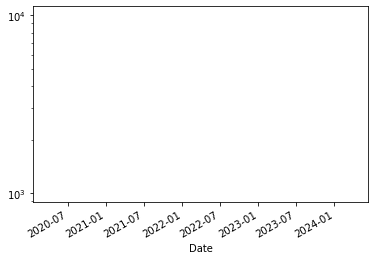

In [8]:
start_date = rank_history.index[0]
idx_values = idx_price_history.loc[start_date:, '^GSPC']
idx_values = idx_values/idx_values[0]*start_cash

values.plot(logy=True);
idx_values.plot(logy=True);

(values[-1]/values[0] - 1)/len(values)*252*100

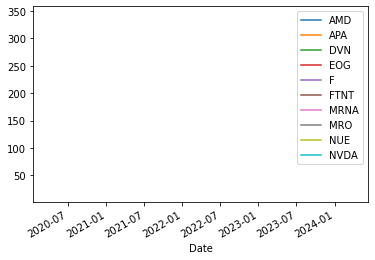

In [9]:
price_history.loc[start_date:, positions.index].plot();